# Using traditional models and feature engineering to classify SHL timeseries

In [1]:
import pathlib

from tools.dataset import load_zipped_shl_dataset

from tqdm.notebook import tqdm

dataset = load_zipped_shl_dataset(pathlib.Path('shl-dataset/challenge-2019-train_torso.zip'), tqdm=tqdm)

Extracting shl-dataset\challenge-2019-train_torso.zip:   0%|          | 0/22 [00:00<?, ?it/s]

Acc_x Import Done
Acc_y Import Done
Acc_z Import Done
Acc_mag Import Done
Mag_x Import Done
Mag_y Import Done
Mag_z Import Done
Mag_mag Import Done
Gyr_x Import Done
Gyr_y Import Done
Gyr_z Import Done
Gyr_mag Import Done
Labels Import Done


In [2]:
from sklearn.preprocessing import PowerTransformer

acc_scaler = PowerTransformer()
mag_scaler = PowerTransformer()
gyr_scaler = PowerTransformer()
acc_mag_scaled = acc_scaler.fit_transform(dataset.acc_mag)
mag_mag_scaled = mag_scaler.fit_transform(dataset.mag_mag)
gyr_mag_scaled = gyr_scaler.fit_transform(dataset.gyr_mag)

In [3]:
import numpy as np

from scipy import signal
from scipy.special import entr


def magnitude(x,y,z):
  return np.sqrt(x**2 + y**2 + z**2)

def entrop(pk,axis=0):
     pk = pk / np.sum(pk, axis=axis, keepdims=True)
     vec = entr(pk)
     S = np.sum(vec, axis=axis)
     return S

def autocorr(x,axis=0):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

# Statistical Feature Calculation
acc_mean = np.mean(acc_mag_scaled,axis=1)
acc_std = np.std(acc_mag_scaled,axis=1)
acc_max = np.max(acc_mag_scaled,axis=1)
acc_min = np.min(acc_mag_scaled,axis=1)

mag_mean = np.mean(mag_mag_scaled,axis=1)
mag_std = np.std(mag_mag_scaled,axis=1)
mag_max = np.max(mag_mag_scaled,axis=1)
mag_min = np.min(mag_mag_scaled,axis=1)

gyr_mean = np.mean(gyr_mag_scaled,axis=1)
gyr_std = np.std(gyr_mag_scaled,axis=1)
gyr_max = np.max(gyr_mag_scaled,axis=1)
gyr_min = np.min(gyr_mag_scaled,axis=1)

# Frequency Domain Feature Calculation
fs = 100
acc_FREQ,acc_PSD = signal.welch(acc_mag_scaled,fs,nperseg=500,axis=1)
mag_FREQ,mag_PSD = signal.welch(mag_mag_scaled,fs,nperseg=500,axis=1)
gyr_FREQ,gyr_PSD = signal.welch(gyr_mag_scaled,fs,nperseg=500,axis=1)

# Max PSD value
acc_PSDmax = np.max(acc_PSD,axis=1)
mag_PSDmax = np.max(mag_PSD,axis=1)
gyr_PSDmax = np.max(gyr_PSD,axis=1)
acc_PSDmin = np.min(acc_PSD,axis=1)
mag_PSDmin = np.min(mag_PSD,axis=1)
gyr_PSDmin = np.min(gyr_PSD,axis=1)

# Frequency Entropy
acc_entropy = entrop(acc_PSD,axis=1)
mag_entropy = entrop(mag_PSD,axis=1)
gyr_entropy = entrop(gyr_PSD,axis=1)

# Frequency Center
acc_fc = np.sum((acc_FREQ*acc_PSD),axis=1) / np.sum(acc_PSD,axis=1)
mag_fc = np.sum((mag_FREQ*mag_PSD),axis=1) / np.sum(mag_PSD,axis=1)
gyr_fc = np.sum((gyr_FREQ*gyr_PSD),axis=1) / np.sum(gyr_PSD,axis=1)

# Autocorrelation Calculation
acc_acr = np.apply_along_axis(autocorr,1,acc_mag_scaled)
mag_acr = np.apply_along_axis(autocorr,1,mag_mag_scaled)
gyr_acr = np.apply_along_axis(autocorr,1,gyr_mag_scaled)

acc_features = np.stack((acc_mean,acc_std,acc_max,acc_min,acc_PSDmax,acc_PSDmin,acc_entropy,acc_fc),axis=1)
mag_features = np.stack((mag_mean,mag_std,mag_max,mag_min,mag_PSDmax,mag_PSDmin,mag_entropy,mag_fc),axis=1)
gyr_features = np.stack((gyr_mean,gyr_std,gyr_max,gyr_min,gyr_PSDmax,gyr_PSDmin,gyr_entropy,gyr_fc),axis=1)

X = np.concatenate([acc_features,mag_features,gyr_features],axis=1)
y = dataset.labels

print("X shape: ",X.shape)
print("y shape: ",y.shape)

print("Feature Extraction Done")

X shape:  (196072, 24)
y shape:  (196072,)
Feature Extraction Done


In [4]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for unbiased training
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

Acc of Nearest Neighbors: 0.6847026458951533
Acc of Linear SVM: 0.6794324925816023
Acc of Gaussian Process: 0.7546828635014837
Acc of Decision Tree: 0.6730804896142433
Acc of Random Forest: 0.6438705489614244
Acc of MLP: 0.7307894411473789
Acc of AdaBoost: 0.45165677546983185
Acc of Naive Bayes: 0.6159124629080118
Acc of QDA: 0.6304556132542037


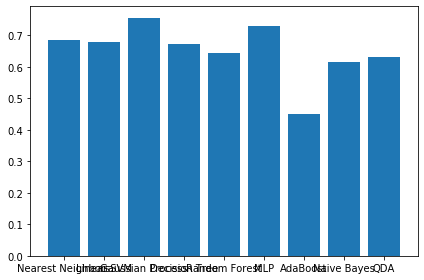

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = [
    "Nearest Neighbors", "Linear SVM", "Gaussian Process",
    "Decision Tree", "Random Forest", "MLP", "AdaBoost",
    "Naive Bayes", "QDA"
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=1337)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

accuracies = []
for model_name, model in zip(names, classifiers):
    model.fit(X_train[:5000], y_train[:5000]) # limit samples to get faster results
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Acc of {model_name}: {accuracy}')

plt.bar(names, accuracies)
plt.tight_layout()
plt.show()